# doing some more benchmarking

Now we have chrombpnet averaged over the folds. We also will redo the calculations based on how chrombpnet does theirs. No need for softmax, we already have it sofmaxed, but can do log fold change or something

Idk this metric seems pretyt damn good...

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

import random
import os
import argparse
import pandas as pd
data = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/dsqtls.yoruba.lcls.benchmarking.all.tsv', sep='\t')
dataf = data[data["var.isused"]]
# dataf
#let's remake our data with this

gkm_svm = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
es = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/GSE31388_dsQtlTable.txt', sep='\t')

gkm_svm['rsid'] = gkm_svm["chrom_hg19"].astype(str) + "_" + gkm_svm["pos_hg19"].astype(str) + "_" + gkm_svm["allele1"].astype(str) + "_" + gkm_svm["allele2"].astype(str)  
es["rsid"] = es["Chr"]+"."+es["SNP"].astype(str)
gkm_svm = gkm_svm.merge(es, left_on=["SNPname1"], right_on='rsid', how="left").drop_duplicates('SNPname1')

#now we will make our names similar1
subset = gkm_svm[['chrom_hg19', 'pos_hg19', 'allele1', 'allele2', 'SNPname2', 'label', 'Estimate']]
#now rename the headers
headers = ['var.chr', 'var.pos_hg19', 'var.allele1', 'var.allele2', 'var.rsid', 'obs.label', 'obs.estimate']
subset.columns = headers

common = set(subset['var.rsid']).intersection(dataf['var.rsid'])
subset_common = subset[subset['var.rsid'].isin(common)].copy()
dataf_common = dataf[dataf['var.rsid'].isin(common)].copy()
dataf_common

,var.chr,var.pos_hg19,var.allele1,var.allele2,var.rsid,obs.label,var.isused,obs.estimate,pred.gkmsvm.encsr000emt.varscore.deltasvm,pred.enformer.encsr000emt.varscore.global_sad,...,pred.chrombpnet.encsr637xsc_50m.varscore.aaq,pred.chrombpnet.encsr637xsc_50m.varscore.ies,pred.chrombpnet.encsr637xsc_50m.varscore.jsd_x_aaq,pred.chrombpnet.encsr637xsc_50m.varscore.logfc_x_aaq,pred.chrombpnet.encsr637xsc_25m.varscore.logfc,pred.chrombpnet.encsr637xsc_25m.varscore.jsd,pred.chrombpnet.encsr637xsc_25m.varscore.ips,pred.chrombpnet.encsr637xsc_5m.varscore.logfc,pred.chrombpnet.encsr637xsc_5m.varscore.jsd,pred.chrombpnet.encsr637xsc_5m.varscore.ips
1,chr1,911595,G,A,rs7417106,1,True,-0.6285,2.821422,-0.001241,...,0.726685,0.002535,0.027762,0.056287,0.093192,0.036053,0.002239,0.045314,0.034489,0.000898
2,chr1,1186502,T,A,rs6603785,1,True,-0.7363,-7.167236,-0.006530,...,0.696101,0.021468,0.029658,0.349964,-0.402188,-0.038791,0.008839,-0.163023,-0.039080,0.002210
5,chr1,3369847,G,A,rs55665824,1,True,-0.7405,-5.249735,-0.000413,...,0.132793,0.033764,0.012280,0.057056,-0.170233,-0.049884,0.001048,-0.036767,-0.010099,0.000094
6,chr1,11809402,G,T,rs11121820,1,True,-0.9398,-1.585787,-0.000722,...,0.419452,0.001206,0.008571,0.025885,-0.145727,-0.032714,0.001238,-0.055247,-0.034108,0.000448
7,chr1,12042261,A,G,rs2236055,1,True,1.1630,2.366937,0.000254,...,0.256384,0.024554,0.021864,0.080476,0.247967,0.084222,0.004846,0.050511,0.022907,0.000337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28302,chr9,140938183,A,G,rs3750506,-1,True,NaN,0.487228,0.000005,...,0.015465,0.000287,0.000093,0.000505,-0.046869,-0.008768,0.000026,-0.026908,-0.006874,0.000050
28303,chr9,140953297,G,A,rs10780199,-1,True,NaN,2.804388,-0.000003,...,0.006603,0.000057,0.000028,0.000094,0.016504,0.005610,0.000002,0.002748,0.003831,0.000002
28304,chr9,141035586,T,C,rs7852209,-1,True,NaN,0.444036,0.000001,...,0.025047,0.000059,0.000146,0.000272,-0.017531,-0.006130,0.000007,-0.005638,-0.005843,0.000012
28305,chr9,141061300,T,C,rs4066694,-1,True,NaN,1.363332,0.000005,...,0.014079,0.000292,0.000122,0.000375,0.012734,0.005202,0.000001,0.004291,0.006334,0.000001


In [4]:
#ran on hg38, let's now get our values to ensure they match with the first 100
import pandas as pd
import numpy as np
full_preds = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/dsqtl_models/var_preds_allfolds.npz')
print(full_preds['counts'].shape)
print(full_preds['profile'].shape)

from scipy.spatial.distance import jensenshannon
def softmax(x, temp=1):
    norm_x = x - np.mean(x, axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)
def get_variant_scores(allele1_pred_counts, allele2_pred_counts,
                       allele1_pred_profiles, allele2_pred_profiles):

    # print('allele1_pred_counts shape:', allele1_pred_counts.shape)
    # print('allele2_pred_counts shape:', allele2_pred_counts.shape)
    # print('allele1_pred_profiles shape:', allele1_pred_profiles.shape)
    # print('allele2_pred_profiles shape:', allele2_pred_profiles.shape)

    logfc = np.squeeze(np.log2(allele2_pred_counts / allele1_pred_counts))
    jsd = np.squeeze([jensenshannon(x, y, base=2.0)
                     for x,y in zip(softmax(allele2_pred_profiles),
                                    softmax(allele1_pred_profiles))])
    ies = logfc * jsd
    return logfc, jsd, ies
counts = full_preds['counts']
profiles = full_preds['profile']

(17506, 5, 1, 4)
(17506, 5, 1000, 4)


In [5]:
logfc = np.zeros(counts.shape[0], dtype=np.float64)
jsd = np.zeros(counts.shape[0], dtype=np.float64)
ies = np.zeros(counts.shape[0], dtype=np.float64)
for fold in range(5):
    temp_counts = counts[:,fold]
    temp_profiles = profiles[:,fold]
    # print(temp_counts.shape, temp_profiles.shape) #(17506, 1, 4) (17506, 1000, 4)
    counts_allele1 = (np.exp(temp_counts[:,0,0]) + np.exp(temp_counts[:,0,1]))/2
    counts_allele2 = (np.exp(temp_counts[:,0,2]) + np.exp(temp_counts[:,0,3]))/2
    
    profiles_allele1 = (temp_profiles[:,:,0] + temp_profiles[:,:,1][:,::-1]) / 2
    profiles_allele2 = (temp_profiles[:,:,2] + temp_profiles[:,:,3][:,::-1]) / 2
    
    templogfc, tempjsd, tempies = get_variant_scores(counts_allele1, counts_allele2,
                       profiles_allele1, profiles_allele2)
    logfc += templogfc
    jsd += tempjsd
    ies += tempies
logfc /= 5
jsd /= 5
ies /= 5

In [8]:
#and now let's load in the results form training on just DNase
pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
out = get_variant_scores(pred_cbp['counts'][:,0,0], pred_cbp['counts'][:,0,1], pred_cbp['profile'][:,:,0], pred_cbp['profile'][:,:,1])

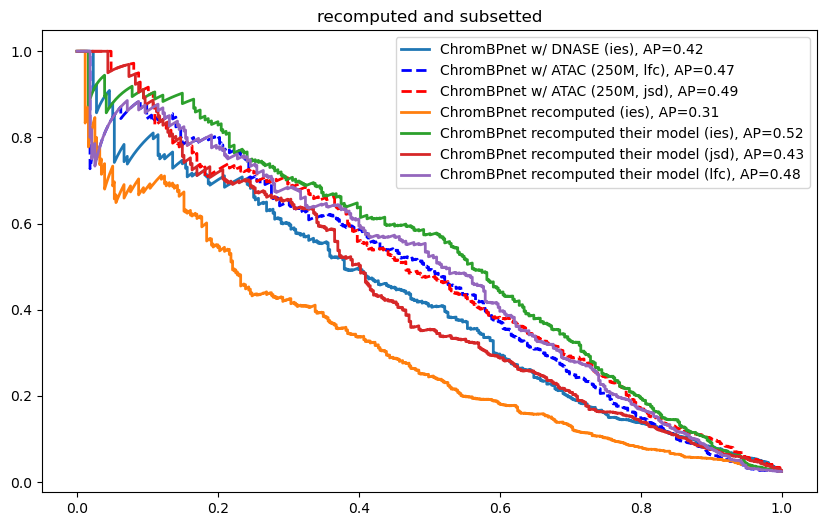

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

keyd="pred.chrombpnet.encsr000emt.varscore.ies"
label=dataf_common["obs.label"].astype(int)
score=abs(dataf_common[keyd])

title="ChromBPnet w/ DNASE (ies)"

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(label,score)
roc_auc = metrics.average_precision_score(label, score)
ax.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label=title+", AP="+str(round(roc_auc,2)))

keyd='pred.chrombpnet.encsr637xsc_250m.varscore.logfc'
label=dataf_common["obs.label"].astype(int)
score=abs(dataf_common[keyd])

title="ChromBPnet w/ ATAC (250M, lfc)"

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(label,score)
roc_auc = metrics.average_precision_score(label, score)
ax.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, c='blue', linestyle='dashed', label=title+", AP="+str(round(roc_auc,2)))

keyd='pred.chrombpnet.encsr637xsc_250m.varscore.jsd'
label=dataf_common["obs.label"].astype(int)
score=abs(dataf_common[keyd])

title="ChromBPnet w/ ATAC (250M, jsd)"

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(label,score)
roc_auc = metrics.average_precision_score(label, score)
ax.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, c='red', linestyle='dashed', label=title+", AP="+str(round(roc_auc,2)))


label=gkm_svm["label"][subset['var.rsid'].isin(common)].astype(int)
score=abs(out[2])[subset['var.rsid'].isin(common)]
title="ChromBPnet recomputed (ies)"

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(label,score)
roc_auc = metrics.average_precision_score(label, score)
ax.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label=title+", AP="+str(round(roc_auc,2)))

label=gkm_svm["label"][subset['var.rsid'].isin(common)].astype(int)
score=abs(ies)[subset['var.rsid'].isin(common)]
title="ChromBPnet recomputed their model (ies)"

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(label,score)
roc_auc = metrics.average_precision_score(label, score)
ax.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label=title+", AP="+str(round(roc_auc,2)))

label=gkm_svm["label"][subset['var.rsid'].isin(common)].astype(int)
score=abs(jsd)[subset['var.rsid'].isin(common)]
title="ChromBPnet recomputed their model (jsd)"

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(label,score)
roc_auc = metrics.average_precision_score(label, score)
ax.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label=title+", AP="+str(round(roc_auc,2)))

label=gkm_svm["label"][subset['var.rsid'].isin(common)].astype(int)
score=abs(logfc)[subset['var.rsid'].isin(common)]
title="ChromBPnet recomputed their model (lfc)"

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(label,score)
roc_auc = metrics.average_precision_score(label, score)
ax.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label=title+", AP="+str(round(roc_auc,2)))

ax.set_title('recomputed and subsetted')

ax.legend()

In [22]:
#now we need to compute the values for logfc for the joint model


import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2

# m0 = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/base_dsqtl_mask_0.npy')
# m50 = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/base_dsqtl_mask_50.npy')
# m100 = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/base_dsqtl_mask_100.npy')
# m1000 = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/base_dsqtl_mask_1000.npy')
# m2000 = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/base_dsqtl_mask_2000.npy')

#list of files is "nomlm_dsqtl.npy" "15mlm_dsqtl.npy" "new_acc_dsqtl.npy" "no_acc_input_dsqtl.npy"
enformer_retrained = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/enformer_dsqtl_retrained-dsqtl.npy')

enformer_retrained.shape

(17506, 896, 2)

In [11]:
allele1 = enformer_retrained[:,:,0]
allele2 = enformer_retrained[:,:,1]
np.sum(np.abs(np.log(allele1) - np.log(allele2)), axis=1).shape

(17506,)

In [12]:
np.array([jensenshannon(x,y) for x,y in zip(allele1, allele2)]).shape

(17506,)

In [17]:
np.log2(allele1.mean(1) / allele2.mean(1)).shape

(17506,)

In [23]:
out = predict_snp_effect_scores(allele1, allele2)
out[0].shape, out[1].shape, out[2].shape, out[3].shape, out[4].shape

((17506,), (17506,), (17506,), (17506,), (17506,))

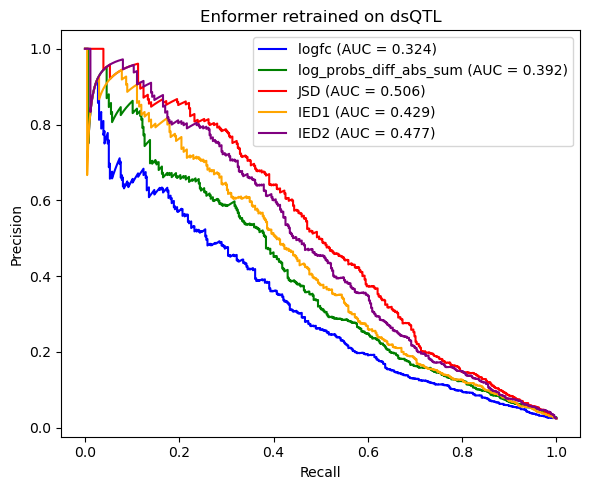

In [28]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
labels = qtls['label'].to_numpy()

plot_metrics(out, labels, 'Enformer retrained on dsQTL')

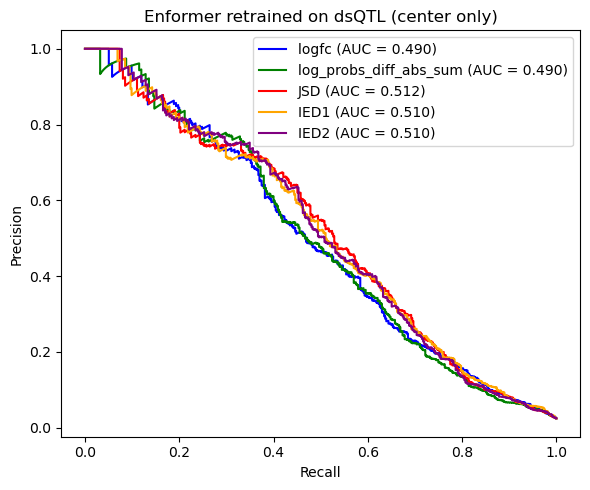

In [29]:
#if we only use the center bins

out = predict_snp_effect_scores(enformer_retrained[:,440:456,0], enformer_retrained[:,440:456,1])
plot_metrics(out, labels, 'Enformer retrained on dsQTL (center only)')

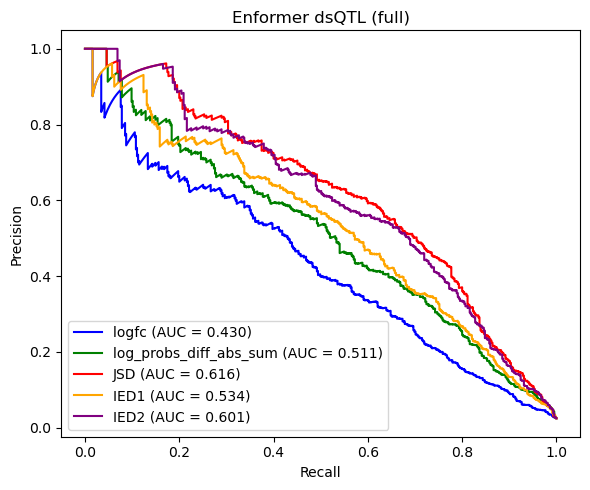

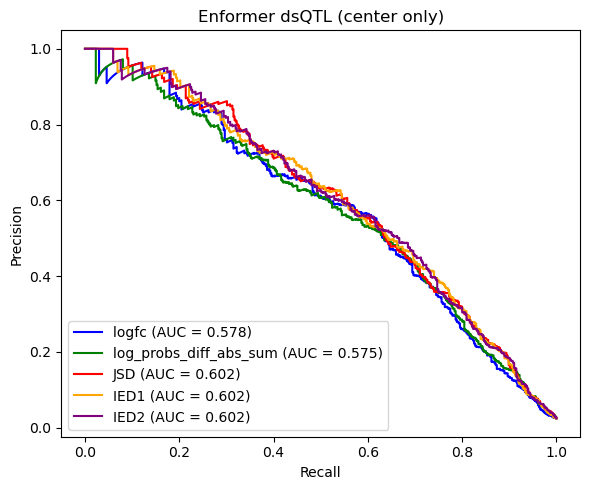

In [ ]:
enformer_preds = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/enformer_dsqtl.npy')
out = predict_snp_effect_scores(enformer_preds[:,:,0], enformer_preds[:,:,1])
plot_metrics(out, labels, 'Enformer dsQTL (full)')
out = predict_snp_effect_scores(enformer_preds[:,440:456,0], enformer_preds[:,440:456,1])
plot_metrics(out, labels, 'Enformer dsQTL (center only)')

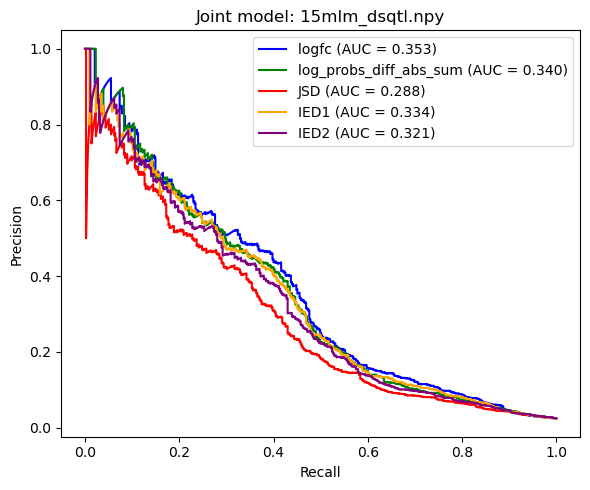

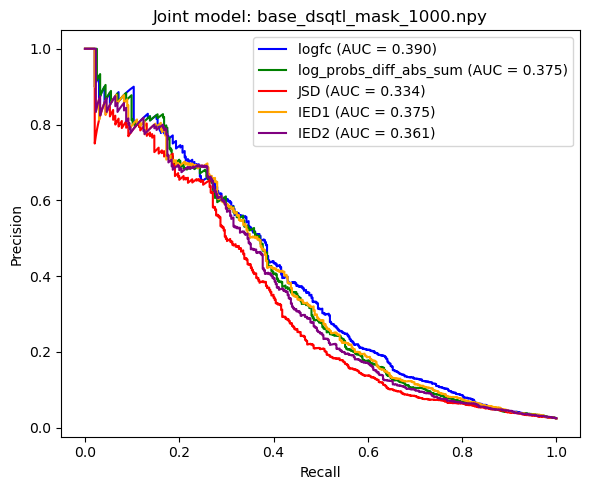

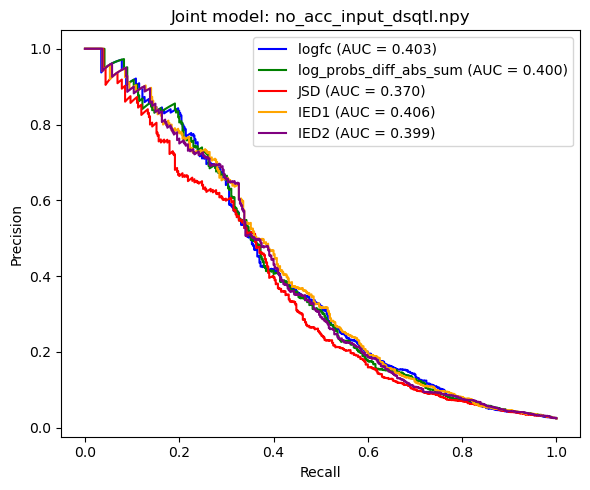

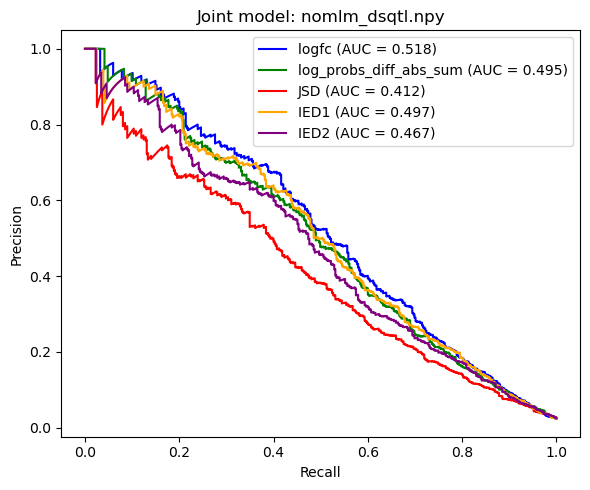

In [33]:
#Now plot several joint models

files = ['15mlm_dsqtl.npy', 'base_dsqtl_mask_1000.npy', 'no_acc_input_dsqtl.npy', 'nomlm_dsqtl.npy']

for file in files:
    preds = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/' + file)
    out = predict_snp_effect_scores(preds[:,:,0], preds[:,:,1])
    plot_metrics(out, labels, 'Joint model: ' + file)

In [48]:
#and then we can do chrombpnet but use different function to account fo rcount vs profile

def softmax(x, temp=1):
    norm_x = x - np.mean(x, axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds, ref_count_preds, alt_count_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    
    print(ref_prob_preds.shape, alt_prob_preds.shape, ref_count_preds.shape, alt_count_preds.shape)
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    #and account for nan
    log_probs_diff_abs_sum[np.isnan(log_probs_diff_abs_sum)] = 0
    # probs_jsd_diff = np.array([jensenshannon(softmax(x),softmax(y)) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    probs_jsd_diff = np.squeeze([jensenshannon(x, y, base=2.0)
                     for x,y in zip(softmax(alt_prob_preds),
                                    softmax(ref_prob_preds))])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_count_preds/alt_count_preds)[:,0]
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2

pred_cbp2 = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/dsqtl_models/var_preds.npz')
# print(pred_cbp2['counts'].shape, pred_cbp2['profile'].shape)
out = predict_snp_effect_scores(pred_cbp2['profile'][:,:,0], pred_cbp2['profile'][:,:,1], pred_cbp2['counts'][:,:,0], pred_cbp2['counts'][:,:,1])
print(out[0].shape, out[1].shape, out[2].shape, out[3].shape, out[4].shape)

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


(17506,) (17506,) (17506,) (17506,) (17506,)


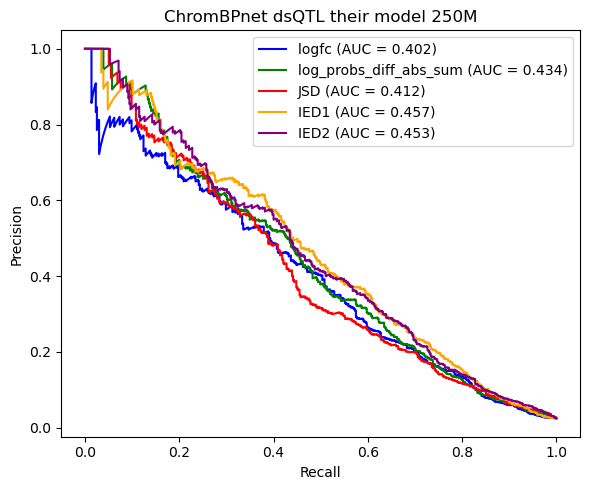

In [44]:
#plot
plot_metrics(out, labels, 'ChromBPnet dsQTL their model 250M')

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_943912/3615852017.py:26: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


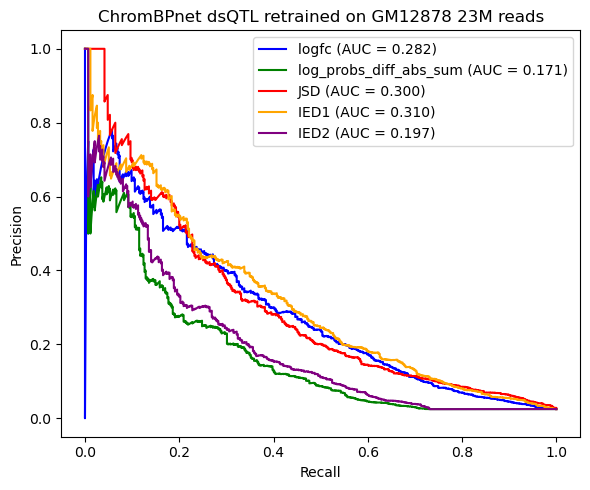

In [50]:
#now do it again but for the enformer that we retrained
pred_cbp = '/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz'
pred_cbp = np.load(pred_cbp)
out = predict_snp_effect_scores(pred_cbp['profile'][:,:,0], pred_cbp['profile'][:,:,1], pred_cbp['counts'][:,:,0], pred_cbp['counts'][:,:,1])
plot_metrics(out, labels, 'ChromBPnet dsQTL retrained on GM12878 23M reads')

In [ ]:
#could summarize over 5 folds too, look at recreating_dsqtl2.ipynb in chrombpnet code_test
#but not worth it today lol.

# direction of effect too

In [52]:
import pandas as pd
import pyfaidx

dataf = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/dsqtls.yoruba.lcls.benchmarking.all.tsv', sep='\t')
dataf = dataf[dataf["var.isused"]]
gkm_svm = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
es = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/GSE31388_dsQtlTable.txt', sep='\t')
gkm_svm['rsid'] = gkm_svm["chrom_hg19"].astype(str) + "_" + gkm_svm["pos_hg19"].astype(str) + "_" + gkm_svm["allele1"].astype(str) + "_" + gkm_svm["allele2"].astype(str)
es["rsid"] = es["Chr"]+"."+es["SNP"].astype(str)
gkm_svm = gkm_svm.merge(es, left_on=["SNPname1"], right_on='rsid', how="left").drop_duplicates('SNPname1')
#now we will make our names similar1
subset = gkm_svm[['chrom_hg19', 'pos_hg19', 'allele1', 'allele2', 'SNPname2', 'label', 'Estimate']]
#now rename the headers
headers = ['var.chr', 'var.pos_hg19', 'var.allele1', 'var.allele2', 'var.rsid', 'obs.label', 'obs.estimate']
subset.columns = headers
common = set(subset['var.rsid']).intersection(dataf['var.rsid'])
subset_common = subset[subset['var.rsid'].isin(common)].copy()
dataf_common = dataf[dataf['var.rsid'].isin(common)].copy()

genome_hg19 = pyfaidx.Fasta('/data1/lesliec/sarthak/data/chrombpnet_test/hg19.fa')

ref_match = []
for i in range(subset.shape[0]):
    vals = subset.iloc[i]
    chrom = vals['var.chr']
    pos = vals['var.pos_hg19'] - 1
    allele1 = vals['var.allele1']
    allele2 = vals['var.allele2']
    
    true_seq = genome_hg19[chrom][pos:pos+1].seq
    # print(true_seq)
    # print(vals)
    # break
    if true_seq.upper() == allele1:
        ref_match.append(1)
    elif true_seq.upper() == allele2:
        ref_match.append(-1)
    else:
        print(vals)
        print(true_seq)
        raise ValueError("Allele not found in genome")
ref_match = np.array(ref_match)

In [53]:
def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2

pred = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/enformer_dsqtl.npy')
out = predict_snp_effect_scores(pred[:,:,0], pred[:,:,1])
out[0].shape, out[1].shape, out[2].shape, out[3].shape, out[4].shape

((17506,), (17506,), (17506,), (17506,), (17506,))

(435, 2)
PearsonRResult(statistic=0.622093802974939, pvalue=5.930721957985293e-48)


Text(0.5, 1.0, 'enformer full logfc, Pearsonr = 0.62')

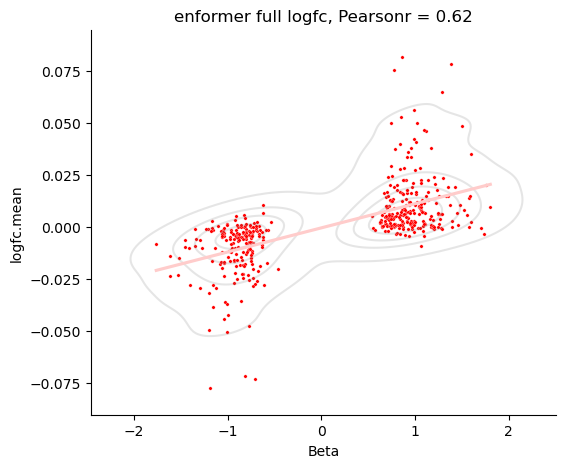

In [56]:
import seaborn as sns
import scipy.stats
key_label = 'obs.label'
obs_estimate = 'obs.estimate'

data = pd.DataFrame()


data["logfc.mean"] = (out[0] * ref_match)[subset[key_label]==1]
data["Beta"] = subset[subset[key_label]==1][obs_estimate]

print(data.shape)
plt.figure(figsize=(6,5))

sns.kdeplot(
    data=data,
    x="Beta",
    y="logfc.mean",
    levels=5,
    fill=False,
    alpha=0.2,
    color="grey",
    cut=2,

)


ax = sns.scatterplot(x="Beta", y="logfc.mean", data=data, s=6, color="Red")
sns.regplot(x="Beta", y="logfc.mean", data=data, scatter=False, ci=None, color="#ffcccb")
ax.spines[["top", "right"]].set_visible(False)

atc_pear = scipy.stats.pearsonr(data['logfc.mean'],data['Beta'])
print(atc_pear)

ax.set_title("enformer full logfc, Pearsonr = "+str(np.round(atc_pear[0],2)))

# atc_pear = scipy.stats.pearsonr(abs(dataf[key][dataf[key_label]==1]),abs(dataf[obs_estimate][dataf[key_label]==1]))

(435, 2)
PearsonRResult(statistic=0.622093802974939, pvalue=5.930721957985293e-48)


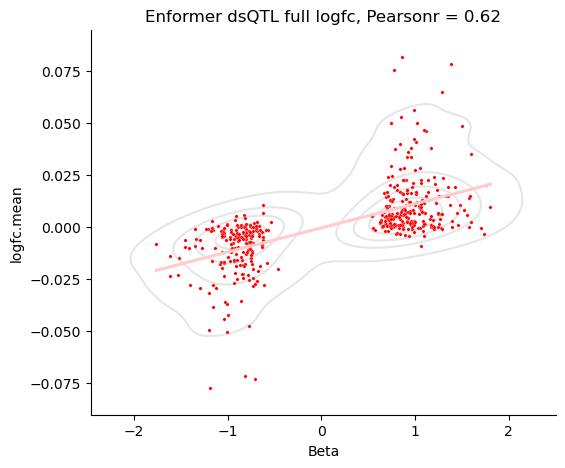

In [61]:
def plot_corr(out, title):
    key_label = 'obs.label'
    obs_estimate = 'obs.estimate'
    data = pd.DataFrame()


    data["logfc.mean"] = (out * ref_match)[subset[key_label]==1]
    data["Beta"] = subset[subset[key_label]==1][obs_estimate]

    print(data.shape)
    plt.figure(figsize=(6,5))

    sns.kdeplot(
        data=data,
        x="Beta",
        y="logfc.mean",
        levels=5,
        fill=False,
        alpha=0.2,
        color="grey",
        cut=2,

    )


    ax = sns.scatterplot(x="Beta", y="logfc.mean", data=data, s=6, color="Red")
    sns.regplot(x="Beta", y="logfc.mean", data=data, scatter=False, ci=None, color="#ffcccb")
    ax.spines[["top", "right"]].set_visible(False)

    atc_pear = scipy.stats.pearsonr(data['logfc.mean'],data['Beta'])
    print(atc_pear)

    ax.set_title(f"{title}, Pearsonr = "+str(np.round(atc_pear[0],2)))
    
    plt.show()
out = predict_snp_effect_scores(pred[:,:,0], pred[:,:,1])
plot_corr(out[0], 'Enformer dsQTL full logfc')

(435, 2)
PearsonRResult(statistic=-0.0063436016090107315, pvalue=0.8950420840515224)


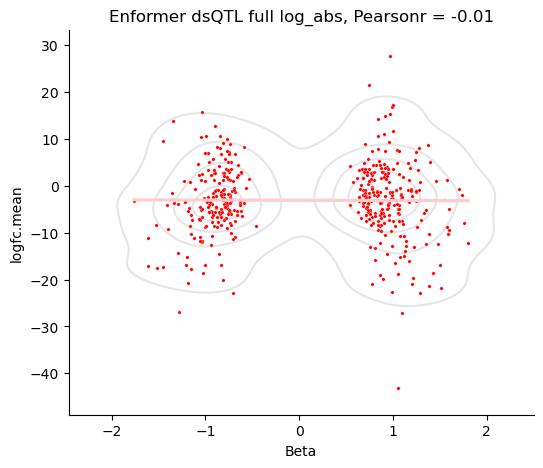

In [ ]:
#and other metric
plot_corr(out[1], 'Enformer dsQTL full log_abs') #it's absolute value of course lol!!

(435, 2)
PearsonRResult(statistic=0.7066620443573179, pvalue=4.7687781735898787e-67)


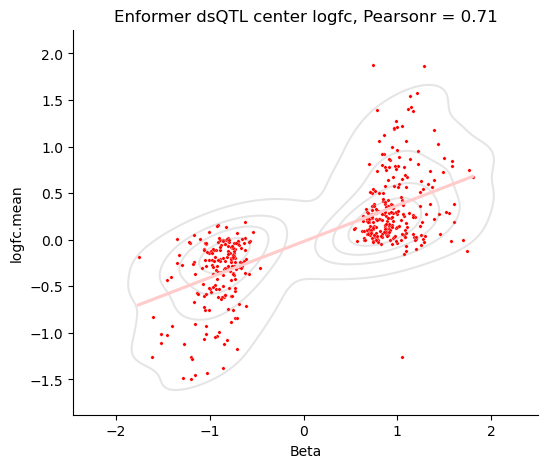

In [59]:
#now enformer partial
out = predict_snp_effect_scores(pred[:,440:456,0], pred[:,440:456,1])
plot_corr(out, 'Enformer dsQTL center logfc')

(435, 2)
PearsonRResult(statistic=0.5695776959771977, pvalue=8.933775073062077e-39)


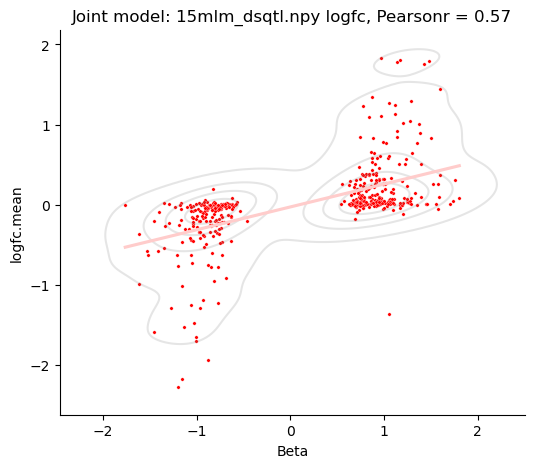

(435, 2)
PearsonRResult(statistic=0.533608469696955, pvalue=2.2154168910719192e-33)


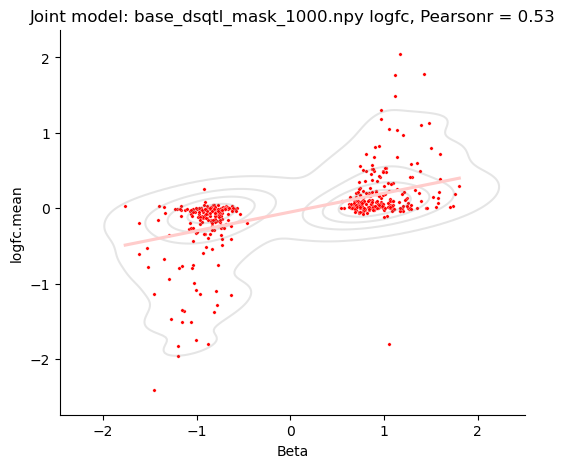

(435, 2)
PearsonRResult(statistic=0.567385017982885, pvalue=1.9907341636437795e-38)


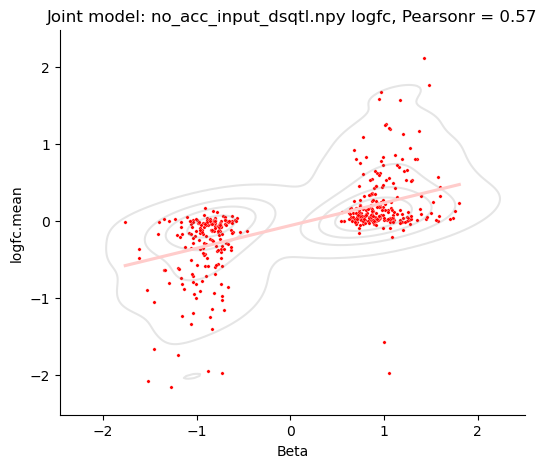

(435, 2)
PearsonRResult(statistic=0.6726053634527929, pvalue=1.3557111279937962e-58)


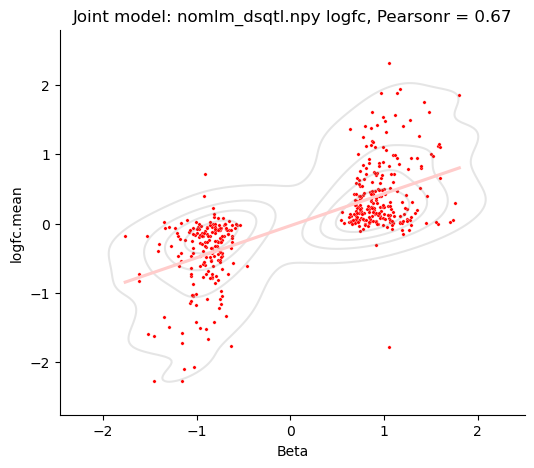

In [63]:
#now the joint model
files = ['15mlm_dsqtl.npy', 'base_dsqtl_mask_1000.npy', 'no_acc_input_dsqtl.npy', 'nomlm_dsqtl.npy']
for file in files:
    preds = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/' + file)
    out = predict_snp_effect_scores(preds[:,:,0], preds[:,:,1])
    plot_corr(out[0], 'Joint model: ' + file + ' logfc')

# and the immune models to see generalizability

In [1]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt


def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2



qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
labels = qtls['label'].to_numpy()



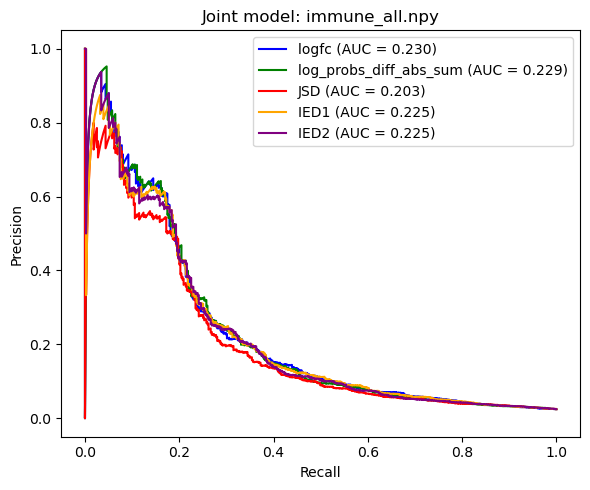

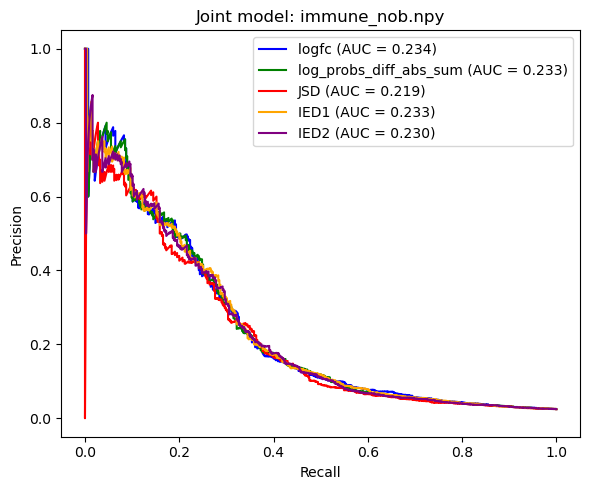

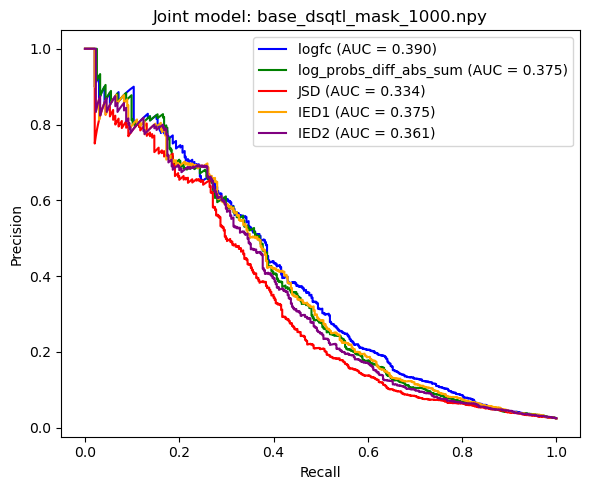

In [4]:
files = ['immune_all.npy', 'immune_nob.npy', 'base_dsqtl_mask_1000.npy']

for file in files:
    preds = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/' + file)
    out = predict_snp_effect_scores(preds[:,:,0], preds[:,:,1])
    plot_metrics(out, labels, 'Joint model: ' + file)

In [11]:
#and we can do direction of effect

import pandas as pd
import pyfaidx
import seaborn as sns
import scipy.stats

dataf = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/dsqtls.yoruba.lcls.benchmarking.all.tsv', sep='\t')
dataf = dataf[dataf["var.isused"]]
gkm_svm = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
es = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/GSE31388_dsQtlTable.txt', sep='\t')
gkm_svm['rsid'] = gkm_svm["chrom_hg19"].astype(str) + "_" + gkm_svm["pos_hg19"].astype(str) + "_" + gkm_svm["allele1"].astype(str) + "_" + gkm_svm["allele2"].astype(str)
es["rsid"] = es["Chr"]+"."+es["SNP"].astype(str)
gkm_svm = gkm_svm.merge(es, left_on=["SNPname1"], right_on='rsid', how="left").drop_duplicates('SNPname1')
#now we will make our names similar1
subset = gkm_svm[['chrom_hg19', 'pos_hg19', 'allele1', 'allele2', 'SNPname2', 'label', 'Estimate']]
#now rename the headers
headers = ['var.chr', 'var.pos_hg19', 'var.allele1', 'var.allele2', 'var.rsid', 'obs.label', 'obs.estimate']
subset.columns = headers
common = set(subset['var.rsid']).intersection(dataf['var.rsid'])
subset_common = subset[subset['var.rsid'].isin(common)].copy()
dataf_common = dataf[dataf['var.rsid'].isin(common)].copy()

genome_hg19 = pyfaidx.Fasta('/data1/lesliec/sarthak/data/chrombpnet_test/hg19.fa')

ref_match = []
for i in range(subset.shape[0]):
    vals = subset.iloc[i]
    chrom = vals['var.chr']
    pos = vals['var.pos_hg19'] - 1
    allele1 = vals['var.allele1']
    allele2 = vals['var.allele2']
    
    true_seq = genome_hg19[chrom][pos:pos+1].seq
    # print(true_seq)
    # print(vals)
    # break
    if true_seq.upper() == allele1:
        ref_match.append(1)
    elif true_seq.upper() == allele2:
        ref_match.append(-1)
    else:
        print(vals)
        print(true_seq)
        raise ValueError("Allele not found in genome")
ref_match = np.array(ref_match)

def plot_corr(out, title):
    key_label = 'obs.label'
    obs_estimate = 'obs.estimate'
    data = pd.DataFrame()


    data["logfc.mean"] = (out * ref_match)[subset[key_label]==1]
    data["Beta"] = subset[subset[key_label]==1][obs_estimate]

    print(data.shape)
    plt.figure(figsize=(6,5))

    sns.kdeplot(
        data=data,
        x="Beta",
        y="logfc.mean",
        levels=5,
        fill=False,
        alpha=0.2,
        color="grey",
        cut=2,

    )


    ax = sns.scatterplot(x="Beta", y="logfc.mean", data=data, s=6, color="Red")
    sns.regplot(x="Beta", y="logfc.mean", data=data, scatter=False, ci=None, color="#ffcccb")
    ax.spines[["top", "right"]].set_visible(False)

    atc_pear = scipy.stats.pearsonr(data['logfc.mean'],data['Beta'])
    print(atc_pear)

    ax.set_title(f"{title}, Pearsonr = "+str(np.round(atc_pear[0],2)))
    
    plt.show()

(435, 2)
PearsonRResult(statistic=0.47467427886021885, pvalue=7.928570312527491e-26)


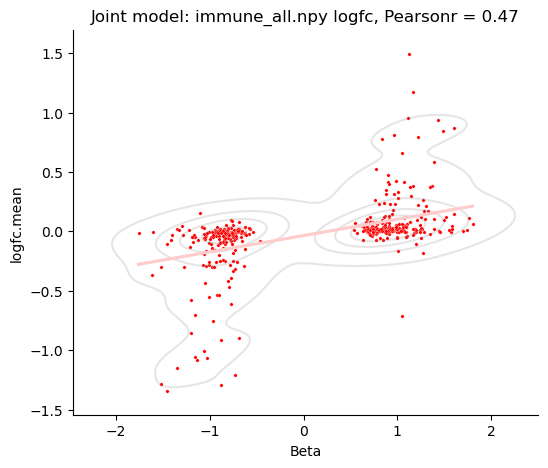

(435, 2)
PearsonRResult(statistic=0.49209124015733535, pvalue=6.571036317972263e-28)


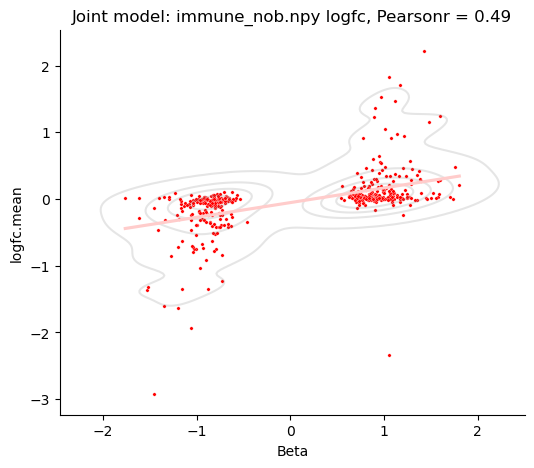

(435, 2)
PearsonRResult(statistic=0.533608469696955, pvalue=2.2154168910719192e-33)


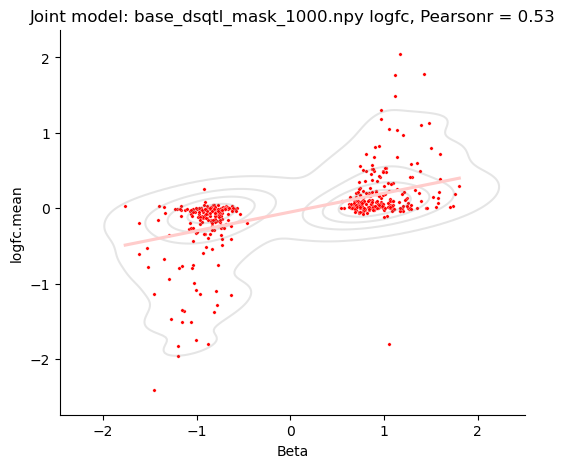

In [12]:

for file in files:
    preds = np.load('/data1/lesliec/sarthak/data/joint_playground/dsQTL/' + file)
    out = predict_snp_effect_scores(preds[:,:,0], preds[:,:,1])
    plot_corr(out[0], 'Joint model: ' + file + ' logfc')